In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import random
import h5py
import torch.nn as nn
import torch.utils.data as udata
from pathlib import Path
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pylab as plt
from sklearn.metrics import mean_absolute_error

нужно прописать адрес доков 

In [3]:
PATH_ROOT = Path('/content/drive/MyDrive/NMA-22/naturalistic_arm_movements_ecog')

In [4]:
data = np.load(PATH_ROOT / "data" / "Naturalistic reach ECoG tfrs ROI" / "power-roi-all-patients.npy")
assert data.shape == (5984, 8, 25, 91)

In [5]:
data_labels = np.load(PATH_ROOT / "data" / "behavior_data" / "latent_space_4.npy")
assert data_labels.shape == (5984, 4)

подготовка трейн и тест выборки

In [6]:
shuffle_ind=np.random.choice(
    np.arange(0, len(data_labels), 1), len(data_labels), replace=False)
print(shuffle_ind.shape)

(5984,)


In [20]:
np.random.choice?

In [7]:
X_shuffle, y_shuffle = data[shuffle_ind], np.array(data_labels[shuffle_ind])

In [8]:
split_7_3 = 4188
split1 = 5500 # 200
split2 = 484 # 20
x_train_0 = torch.tensor(X_shuffle[:split1]).float()
y_train_0 = torch.tensor(y_shuffle[:split1]).float()
x_test_0 = torch.tensor(X_shuffle[split1:split1+split2]).float()
y_test_0 = torch.tensor(y_shuffle[split1:split1+split2]).float()

In [9]:
print(x_train_0.shape)
print(y_train_0.shape)
print(x_test_0.shape)
print(y_test_0.shape)

print(torch.mean(y_train_0))
print(torch.mean(y_test_0))
print(torch.var(y_train_0))
print(torch.var(y_test_0))

torch.Size([5500, 8, 25, 91])
torch.Size([5500, 4])
torch.Size([484, 8, 25, 91])
torch.Size([484, 4])
tensor(0.0164)
tensor(0.0286)
tensor(1.0862)
tensor(1.1101)


In [10]:
def set_device():

  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

DEVICE = set_device()

GPU is enabled in this notebook.


In [11]:
class DnCNN(nn.Module):
    def __init__(self, channels, num_of_layers=4):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 10
        layers = []
        layers.append(nn.Conv2d(
            in_channels=channels,
            out_channels=features,
            kernel_size=kernel_size,
            padding=padding,
            bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=kernel_size,
                padding=padding,
                bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(
            in_channels=features,
            out_channels=channels,
            kernel_size=kernel_size,
            padding=padding,
            bias=False))
        self.dncnn = nn.Sequential(*layers)
        self.fc1 = (nn.Linear(8*25*91, 4))

    def forward(self, x):
        out = self.dncnn(x)
        x_f = torch.flatten(out, 1)
        x_fc1 = self.fc1(x_f)
        return x_fc1

In [12]:
def train(model, X, y, X_test, y_test):
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
  epochs = 25
  train_loss, test_loss = [], []
  outputs = np.empty(1)

  batch_size = 55
  data_length_train, data_length_test = len(y), len(y_test)
  
  for j in range(epochs):
    running_loss_train, running_loss = 0.0 , 0.0
    
    for i in range(data_length_train):
      if i % batch_size == 0:
        data, target = X[i:i+batch_size], y[i:i+batch_size]
        data, target = data.to(DEVICE), target.to(DEVICE)
        model.train()
        model.zero_grad()
        y_logits = model.forward(data)
        loss = loss_function(y_logits, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss_train += loss.item()
    train_loss.append(running_loss_train / y.shape[0])

    # if i % 10 == 0:
    #   print(f"Epoch {i} train loss is {np.mean(train_loss)}")

    model.eval()
    #for (data, target) in zip (X_test, y_test):
    for i in range(data_length_test):
      if i % batch_size == 0:
        data, target = X_test[i:i+batch_size], y_test[i:i+batch_size]
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model.forward(data) 
        # if j == epochs-1 :
        #   print(i)
        #   print(output, '\n',  target)
        loss = loss_function(output, target)
        running_loss += loss.item()

    test_loss.append(running_loss/y_test.shape[0])
    
    if j % 10 == 0:
      print(f"Epoch {j} train loss is {np.mean(running_loss_train / y.shape[0])}, test loss in {np.mean(running_loss/y_test.shape[0])}")


  return train_loss, test_loss,

In [13]:
def plot_loss(train_loss, test_loss):

  epochs = len(train_loss)
  fig, (ax1) = plt.subplots(1)
  ax1.plot(list(range(epochs)), train_loss, label='Train Loss')
  ax1.plot(list(range(epochs)), test_loss, label='Test Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()
  print(f"Min test loss is {min(test_loss)}")

In [14]:
model = DnCNN(channels = 8).to(DEVICE)
train_loss, test_loss = train(model, x_train_0, y_train_0, x_test_0, y_test_0)

Epoch 0 train loss is 0.020586802027442237, test loss in 0.021573395029572416
Epoch 10 train loss is 0.011273867233233018, test loss in 0.02345934263930833
Epoch 20 train loss is 0.0049969185401092875, test loss in 0.028458924332926096


Min test loss is 0.02152214328612178


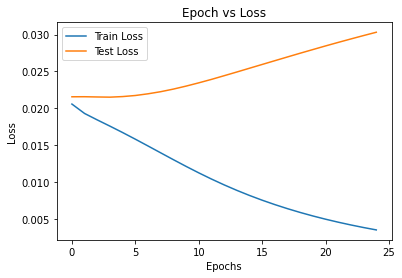

In [15]:
plot_loss(train_loss, test_loss)

Extract predictions for the test data

In [16]:
test_ids = shuffle_ind[split1:split1+split2]

In [17]:
with torch.no_grad():
  prediction = model.forward(x_test_0.to(DEVICE))

In [18]:
# np.save(PATH_ROOT / "data" / "behavior_data" / "DnCNN_prediction.npy", 
#         prediction.to('cpu').numpy())
# np.save(PATH_ROOT / "data" / "behavior_data" / "DnCNN_prediction_data_ids.npy",
#         test_ids)

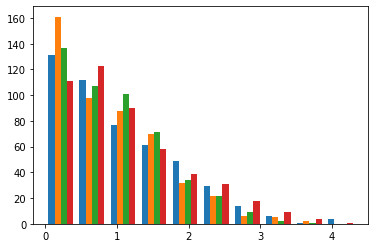

In [19]:
loss_full = torch.nn.functional.l1_loss(
    y_test_0.to('cpu'), prediction.to('cpu'), reduction='none')
plt.hist(loss_full.T)
plt.show()

torch.Size([484, 4])